In [19]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F



def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class BottleNeck(nn.Module):
    
    expansion = 2

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class DICNet(nn.Module):

    def __init__(self, in_channel, out_channel, block, num_block):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv1_x = self._make_layer(block, 64, num_block[5], 2)

        self.conv2_x = self._make_layer(block, 128, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 256, num_block[3], 2)
        self.conv6_x = self._make_layer(block, 512, num_block[4], 2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up4 = double_conv(1024 + 512, 512)
        self.dconv_up3 = double_conv(512 + 512, 256)
        self.dconv_up2 = double_conv(256 + 256, 128)
        self.dconv_up1 = double_conv(128 + 256, 64)

        self.dconv_last = nn.Sequential(
            nn.Conv2d(64+64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True),
            nn.Conv2d(64, out_channel, 1)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        conv1 = self.conv1(x)  
        temp = self.conv1_x(conv1)  
        conv2 = self.conv2_x(temp)  
        conv3 =self.conv3_x(conv2)  
        conv4 = self.conv4_x(conv3) 
        conv5 = self.conv5_x(conv4)
        bottle = self.conv6_x(conv5) 

        x = self.upsample(bottle) 

        x = torch.cat([x, conv5], dim=1) 

        x = self.dconv_up4(x) 
        x = self.upsample(x) 

        x = torch.cat([x, conv4], dim=1) 

        x = self.dconv_up3(x) 
        x = self.upsample(x) 

        x = torch.cat([x, conv3], dim=1)  

        x = self.dconv_up2(x)
        x = self.upsample(x)

        x = torch.cat([x, conv2], dim=1) 

        x = self.dconv_up1(x) 
        x = self.upsample(x)

        x = torch.cat([x, conv1], dim=1) 
        out = self.dconv_last(x)
        return out


def DICNet_d(in_channel,out_channel):

    model = DICNet(in_channel,out_channel,BottleNeck, [5, 6, 8, 5, 3, 1])

    return model

For the code in the next block
* You could select device to be "cpu" or "cuda"
* You must change the path of the ck load file to your model parameter file storage directory


In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
ck = torch.load('H:\\Deep-DIC\\DIC-Net-d\\model_best.pth.tar')# file path of model parameters

model = DICNet_d(2, 2).to(device)
model.load_state_dict(ck['state_dict'])
print(ck)

{'epoch': 40, 'arch': 'resnet', 'state_dict': OrderedDict([('conv1.0.weight', tensor([[[[ 4.5429e-03,  3.6599e-02,  1.7280e-03],
          [-7.7756e-02, -3.1214e-02, -7.0190e-03],
          [-5.6737e-02, -1.5421e-01, -5.0931e-03]],

         [[ 1.4835e-02,  1.8193e-02,  4.5727e-02],
          [ 5.5817e-02,  3.5869e-02,  1.2392e-01],
          [-2.0833e-02,  3.2220e-02, -1.5917e-02]]],


        [[[-1.4401e-02, -5.3757e-02, -4.6020e-02],
          [ 5.9278e-02,  5.6564e-02, -7.5810e-02],
          [ 6.2262e-03,  8.3315e-02,  7.0948e-02]],

         [[ 6.3956e-03,  2.2296e-03,  3.8097e-02],
          [-3.5263e-02,  1.2194e-02, -1.4002e-02],
          [-2.1622e-02, -1.7747e-02, -5.6403e-02]]],


        [[[ 3.6588e-42,  7.9173e-42, -1.1355e-41],
          [-1.2131e-41,  1.0514e-41, -3.9138e-42],
          [ 3.3099e-42, -4.7826e-42, -1.1701e-42]],

         [[-1.2058e-41, -5.7061e-42,  1.1806e-41],
          [-2.7606e-42,  3.9839e-42, -1.2228e-41],
          [-8.7315e-42, -1.2263e-41, -0.0

For the code in the next block
* You must change the path1 and path2 to your image file
* the oder of Ref and Def must be right

In [10]:
import torch
import math
import numpy as np
from PIL import Image
import os
from skimage import io

path1 = 'hole_ref.bmp'#file path of reference image
path2 = 'hole_def.bmp'#file path of deformed image


def speckle_pair(path1, path2, reverse = 1):
    
    Ref = Image.open(path1)
    Def = Image.open(path2)
     

    Ref = np.array(Ref)
    Def = np.array(Def)

    image_h, image_w = Ref.shape
    image_h_new, image_w_new = (math.ceil(image_h/32)*32, math.ceil(image_w/32)*32)

    Ref_new = np.zeros((image_h_new, image_w_new))
    Def_new = np.zeros((image_h_new, image_w_new))

    Ref_new[:image_h,:image_w] = Ref
    Def_new[:image_h,:image_w] = Def
    speckle_pair = np.zeros((2, image_h_new, image_w_new)) 
    
    if reverse == 1:
        speckle_pair[0, :, :] = Ref_new
        speckle_pair[1, :, :] = Def_new
    else:
        speckle_pair[1, :, :] = Ref_new
        speckle_pair[0, :, :] = Def_new
        
    speckle_pair = torch.unsqueeze(torch.from_numpy(speckle_pair), 0).float()

    return speckle_pair, image_h, image_w

speckle_pair,image_h, image_w= speckle_pair(path1, path2, reverse = 0)
speckle_pair.shape,image_h, image_w

(torch.Size([1, 2, 768, 1024]), 767, 1023)

In [18]:
device = torch.device('cpu')
Ref_Def = speckle_pair.to('cpu')
with torch.no_grad():
    model.eval()
    output = model(Ref_Def)
output = output.cpu().numpy()

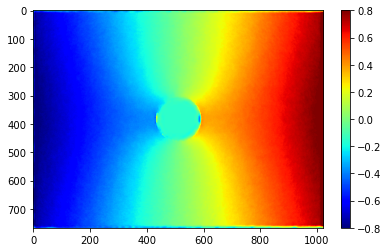

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def DIC_Net_show(output,image_h, image_w,vmax=None,vmin=None, axis = 'u'):
    u = np.zeros((image_h, image_w))
    v = np.zeros((image_h, image_w))
    u[:,:] = output[0,0,:image_h,:image_w]
    v[:,:] = output[0,1,:image_h,:image_w]
    if axis == 'u':
        show_this = u
    elif axis == 'v':
        show_this = v
    ax = plt.subplot()
    im = ax.imshow(show_this,vmax=vmax,vmin=vmin, cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.25)
    plt.colorbar(im, cax=cax)
    
DIC_Net_show(output,image_h, image_w,vmax=0.8,vmin=-0.8,axis = 'u')

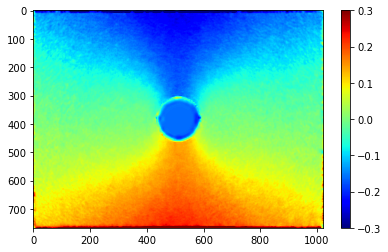

In [16]:
DIC_Net_show(output,image_h, image_w,vmax=0.3,vmin=-0.3,axis = 'v')